In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats

In [2]:
connection = {
    'host': 'HOST',
    'password': 'PASSWORD',
    'user': 'USER',
    'database': 'DATABASE'
}

q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2025-01-24' and toDate(time) <= '2025-01-30' 
"""
pandahouse.read_clickhouse(q, connection=connection)

,user_id
0,11509
1,14946
2,107626
3,117693
4,119016
...,...
41992,133122
41993,13344
41994,2385
41995,131256


In [3]:
#Проверим данные в группах

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-24' and '2025-01-30'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count().reset_index()

,exp_group,user_id,likes,views,ctr
0,2,8362,8362,8362,8362
1,3,8425,8425,8425,8425


Сперва нам необходимо проверить систему сплитования.Для этого 10 000 раз сгенерируем выборку по 500 пользователей из каждой подгруппы и 10 000 раз проведем т-тест, записав p-value в отдельную переменную.

In [4]:
# создадим пустой список для значений p-value

p_values = []

In [5]:
# Проведение t-теста 10 000 раз
for _ in range(10000):
    # Случайная выборка 500 пользователей из каждой группы
    sample_group2 = df[df.exp_group == 2].sample(500, replace=False).ctr
    sample_group3 = df[df.exp_group == 3].sample(500, replace=False).ctr
    
    # Проведение t-теста
    _, p_value = stats.ttest_ind(sample_group2, sample_group3, equal_var=False)
    
    # Сохранение p-value
    p_values.append(p_value)

In [6]:
p_values_df = pd.DataFrame(p_values, columns=['p_value'])

In [7]:
# проверим значения p_value

p_values_df

,p_value
0,0.911577
1,0.936569
2,0.112275
3,0.332180
4,0.453312
...,...
9995,0.141068
9996,0.567857
9997,0.881927
9998,0.998629


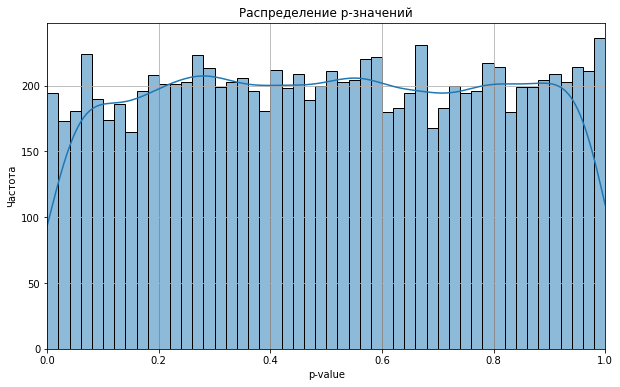

In [8]:
# Визуализация распределения p-значений
plt.figure(figsize=(10, 6))
sns.histplot(p_values_df['p_value'], bins=50, kde=True)
plt.title('Распределение p-значений')
plt.xlabel('p-value')
plt.ylabel('Частота')
plt.xlim(0, 1)  # Ограничение по оси X от 0 до 1
plt.grid()
plt.show()

In [9]:
# Посчитаем отношение p_value менее 5% ко всем значениям p_value
p_values_df.query('p_value < 0.05').count() / p_values_df.count()

p_value    0.0451
dtype: float64

In [10]:
# в менее 5% случаев p-value менее 0.05. Значит система сплитования работает корректно.

Приступим к проведению А/Б теста

In [36]:
#Выгрузим данные и проверим данные в группах

q_2 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-31' and '2025-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_2 = pandahouse.read_clickhouse(q_2, connection=connection)

df_2.groupby('exp_group').count().reset_index()

,exp_group,user_id,likes,views,ctr
0,1,10020,10020,10020,10020
1,2,9877,9877,9877,9877


<Axes: xlabel='ctr', ylabel='Count'>

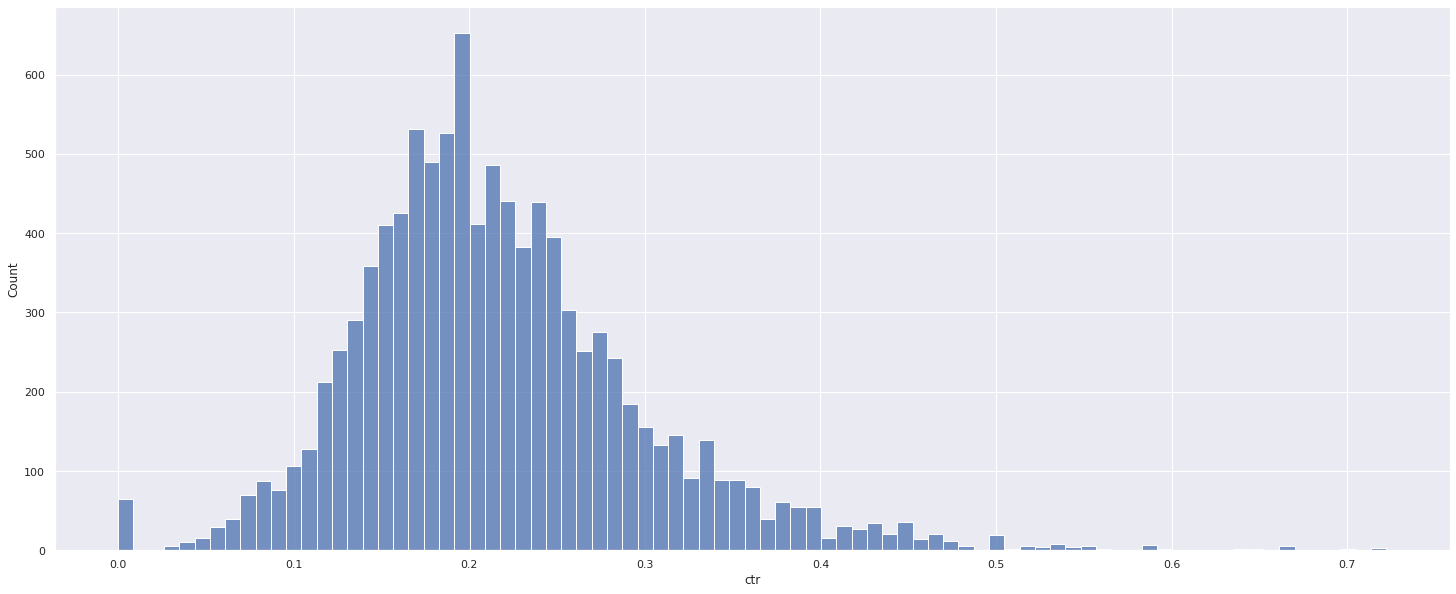

In [37]:
# Построим распределение CTR для первой группы
sns.histplot(df_2.query('exp_group == 1').ctr)

<Axes: xlabel='ctr', ylabel='Count'>

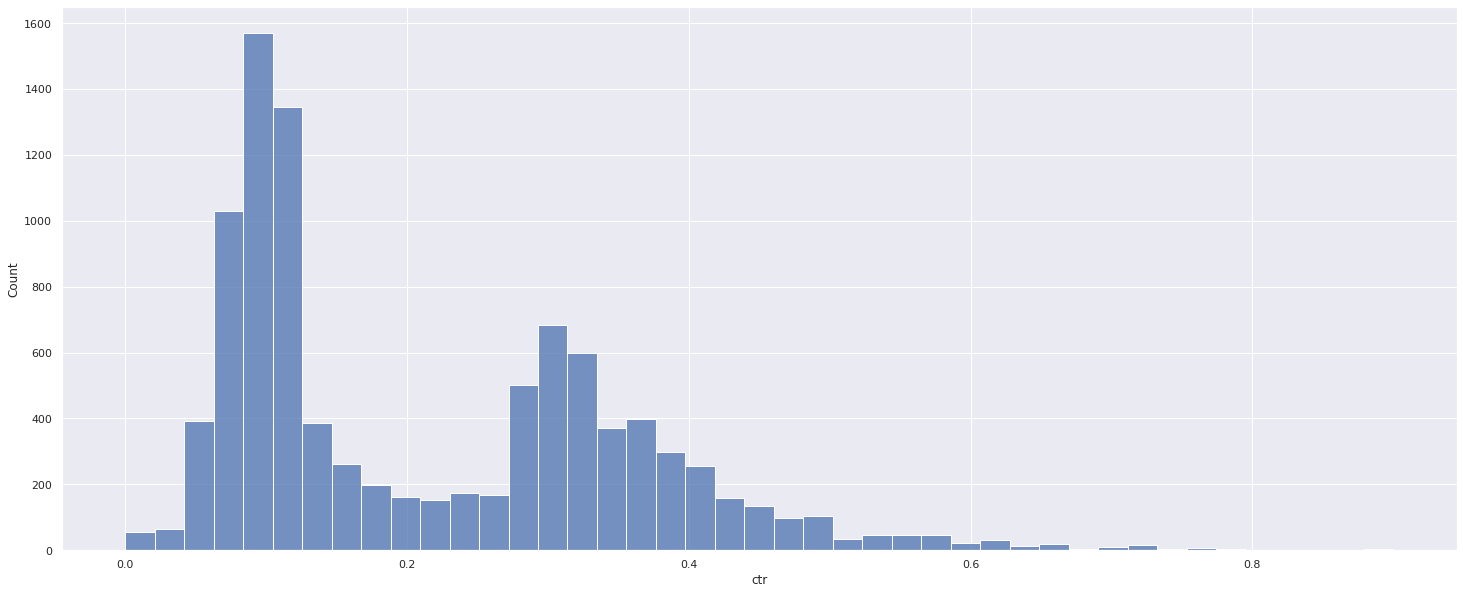

In [38]:
# Построим распределение CTR для второй группы
sns.histplot(df_2.query('exp_group == 2').ctr)

Размеры одной из групп немного меньше. Допустим, что это не повлияет на результаты тестов.

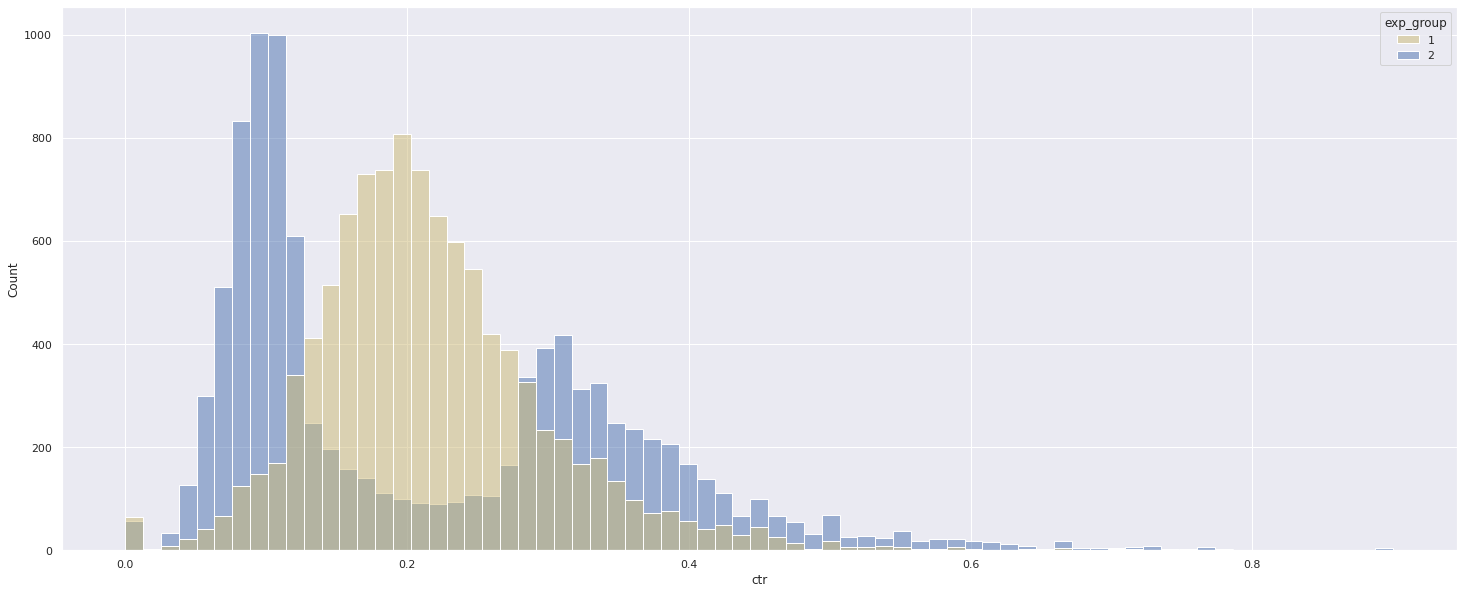

In [35]:
# Сделаем графики в seaborn
sns.set(rc={'figure.figsize':(25,10)})

groups = sns.histplot(data = df_2, 
              x='ctr', 
              hue='exp_group', 
              palette = ['y', 'b'],
              alpha=0.5,
              kde=False)

На гравифках видно, что распределение с новым алгоритмом рекомендаций является бимодальным.

Наилучшим выбором для вашего случая с бимодальным распределением будет тест Манна-Уитни, так как он не требует предположений о нормальности и может корректно обрабатывать данные с нестандартными распределениями.Также обратим внимание на тест Манна-Уитни поверх бакетного преобразования.

t-тест предполагает, что данные в группах нормально распределены. 
Бимодальное распределение, имеющее два пика, явно нарушает это предположение. Это может привести к искажению результатов t-теста и неверным выводам, поэтому опираться на его результаты мы не станем.

Но все равно проведем t-тест ради интереса.

группа 1 - контрольная 
группа 2 - был использован один из новых алгоритмов рекомендации постов

Перед проведением т-теста сперва проверим дисперсии в двух группах.

In [13]:
# Проверка равенства дисперсий с помощью теста Левене
levene_stat, levene_p = stats.levene(df_2.exp_group == 1, df_2.exp_group == 2)
print(f"Тест Левене: статистика = {levene_stat}, p-значение = {levene_p}")

# Проверка равенства дисперсий с помощью теста Бартлетта
bartlett_stat, bartlett_p = stats.bartlett(df_2.exp_group == 1, df_2.exp_group == 2)
print(f"Тест Бартлетта: статистика = {bartlett_stat}, p-значение = {bartlett_p}")

Тест Левене: статистика = 0.0, p-значение = 1.0
Тест Бартлетта: статистика = -7.275774769019347e-12, p-значение = 1.0


Оба теста говорят о том, что мы можем считать дисперсии внутри групп равными.

In [14]:
#T-тест

stats.ttest_ind(df_2[df_2.exp_group == 1].ctr,
                df_2[df_2.exp_group == 2].ctr,
                equal_var=True)

#так как мы уверены в равности дисперсий, то указываем параметр equal_var=True

Ttest_indResult(statistic=0.4065949741045715, pvalue=0.6843098628062774)

Значит т-тест говорит о том, что гипотеза верна и отличий в системе рекомендаций нет.Хоть и верить ему не стоит.

Теперь провеедем А/Б тест с помощью теста Манна-Уитни и Пуассоновского бутстрепа.

In [15]:
# тест Манна-Уитни
stats.mannwhitneyu(df_2[df_2.exp_group == 1].ctr, 
                   df_2[df_2.exp_group == 2].ctr,
                   alternative = 'two-sided')

# Поскольку у нас нет предположений,какая из групп имеет большие значения, выбираем альтернативу two-sided

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [41]:
median_group_1 = df_2[df_2.exp_group == 1].ctr.median()
median_group_2 = df_2[df_2.exp_group == 2].ctr.median()
  

print(f'Median Group 1 (Old System): {median_group_1}')
print(f'Median Group 2 (New System): {median_group_2}')

Median Group 1 (Old System): 0.2058823529411764
Median Group 2 (New System): 0.1532846715328467


In [ ]:
Медианное значение для новой системы рекомендаций ниже, чем медианное значение старой системы рекомендаций.

тест Манна-Уитни показывает стат значимые отличия между группами 

Проверим данные Пуассоновский бутстрепом.

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [17]:
q_3 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-31' and '2025-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

In [18]:
df_3 = pandahouse.read_clickhouse(q_3, connection=connection)

likes1 = df_3[df_3.exp_group == 1].likes.to_numpy()
views1 = df_3[df_3.exp_group == 1].views.to_numpy()
likes2 = df_3[df_3.exp_group == 2].likes.to_numpy()
views2 = df_3[df_3.exp_group == 2].views.to_numpy()

<Axes: ylabel='Count'>

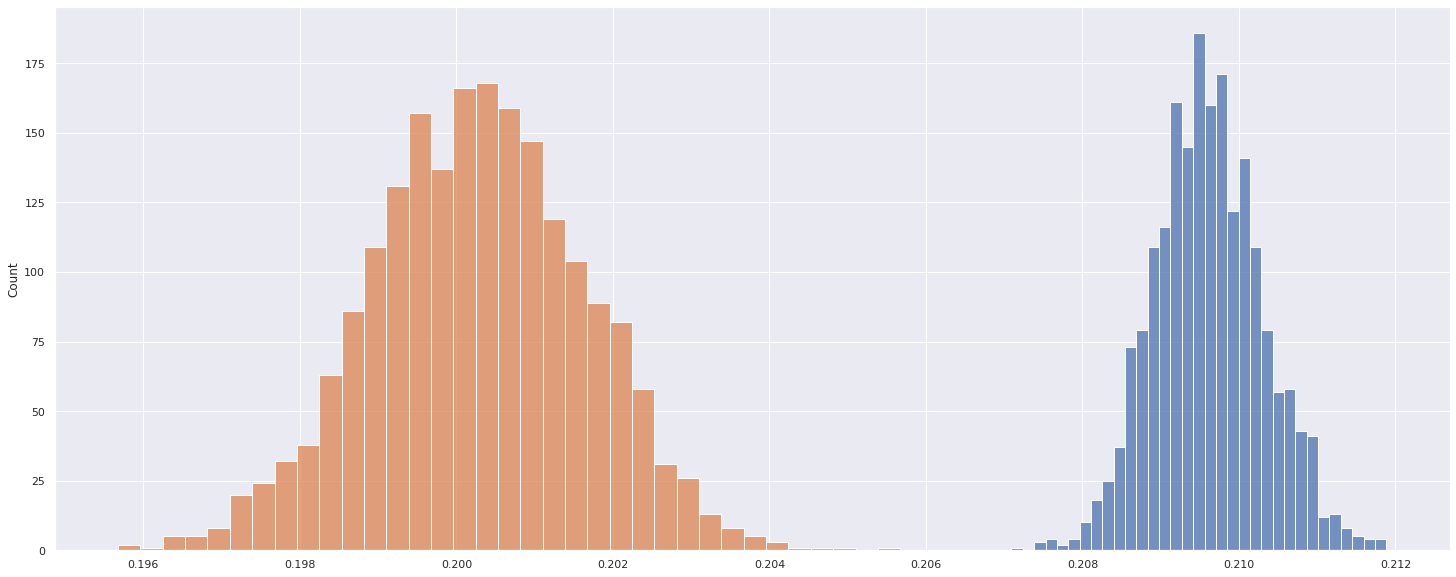

In [31]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

Мы также видим, что CTR у двух групп отличается

Попробуем использовать t-тест на сглаженном CTR.Но на результаты этого теста также не стоит полагаться.
Выполним его просто чтобы вспомнить метод.

In [21]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [22]:
q_4 = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-31' and '2025-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df_4 = pandahouse.read_clickhouse(q_4, connection=connection)

global_ctr_1 = df_4[df_4.exp_group == 1].likes.sum()/df_4[df_4.exp_group == 1].views.sum()
global_ctr_2 = df_4[df_4.exp_group == 2].likes.sum()/df_4[df_4.exp_group == 2].views.sum()

/tmp/ipykernel_141/439781346.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.ctr,
/tmp/ipykernel_141/439781346.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.ctr,


<Axes: xlabel='ctr'>

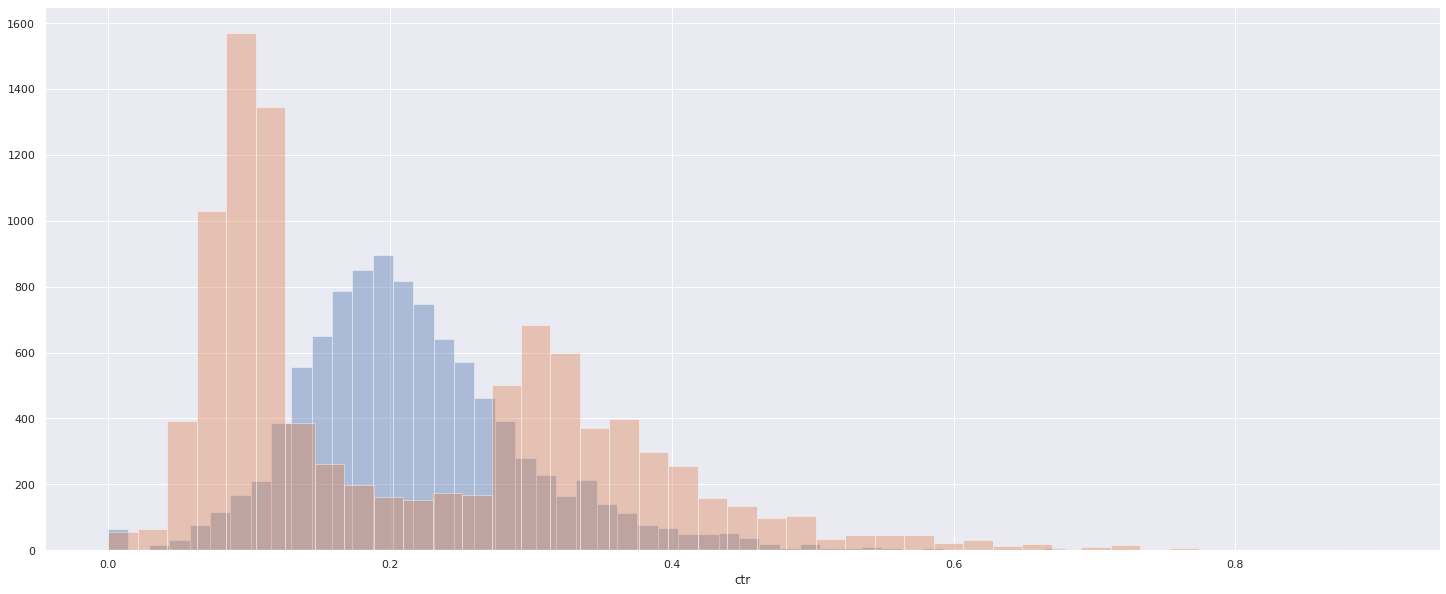

In [23]:
group1 = df_4[df_4.exp_group == 1].copy()
sns.distplot(group1.ctr, 
             kde = False)
group2 = df_4[df_4.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

/tmp/ipykernel_141/3078276053.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1.smothed_ctr,
/tmp/ipykernel_141/3078276053.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group2.smothed_ctr,


<Axes: xlabel='smothed_ctr'>

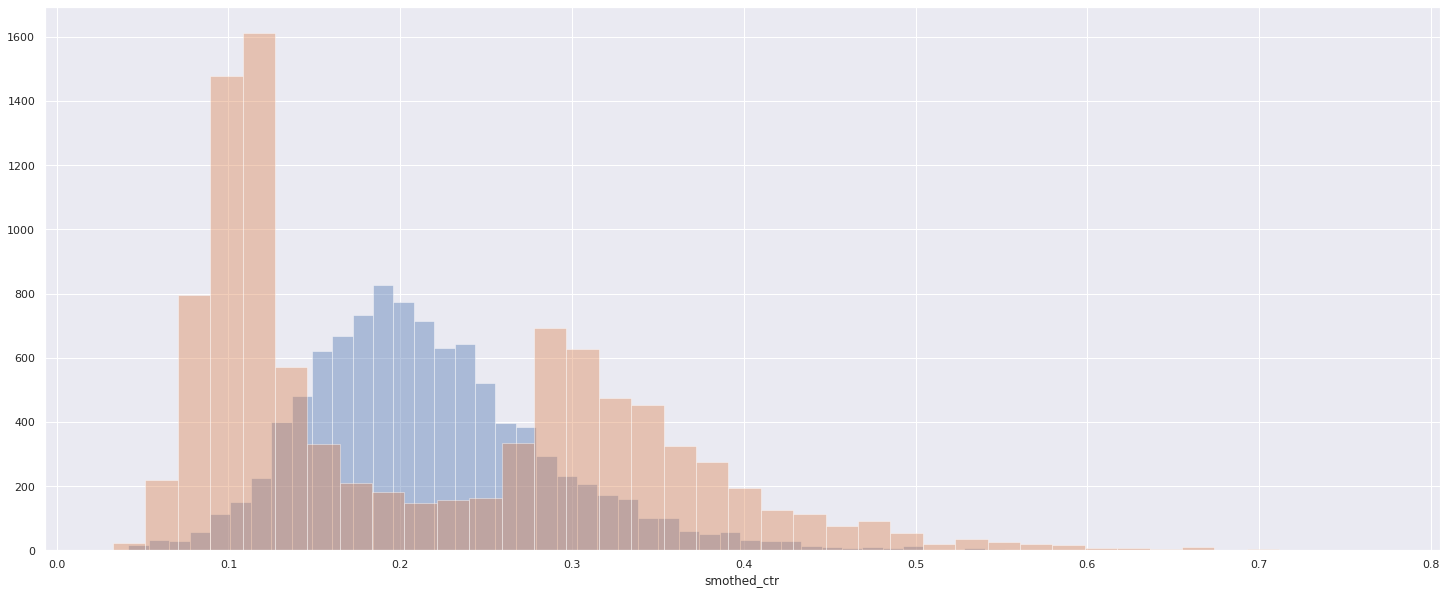

In [24]:
group1['smothed_ctr'] = df_4.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2['smothed_ctr'] = df_4.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)
sns.distplot(group2.smothed_ctr, 
             kde = False)

<Axes: ylabel='Count'>

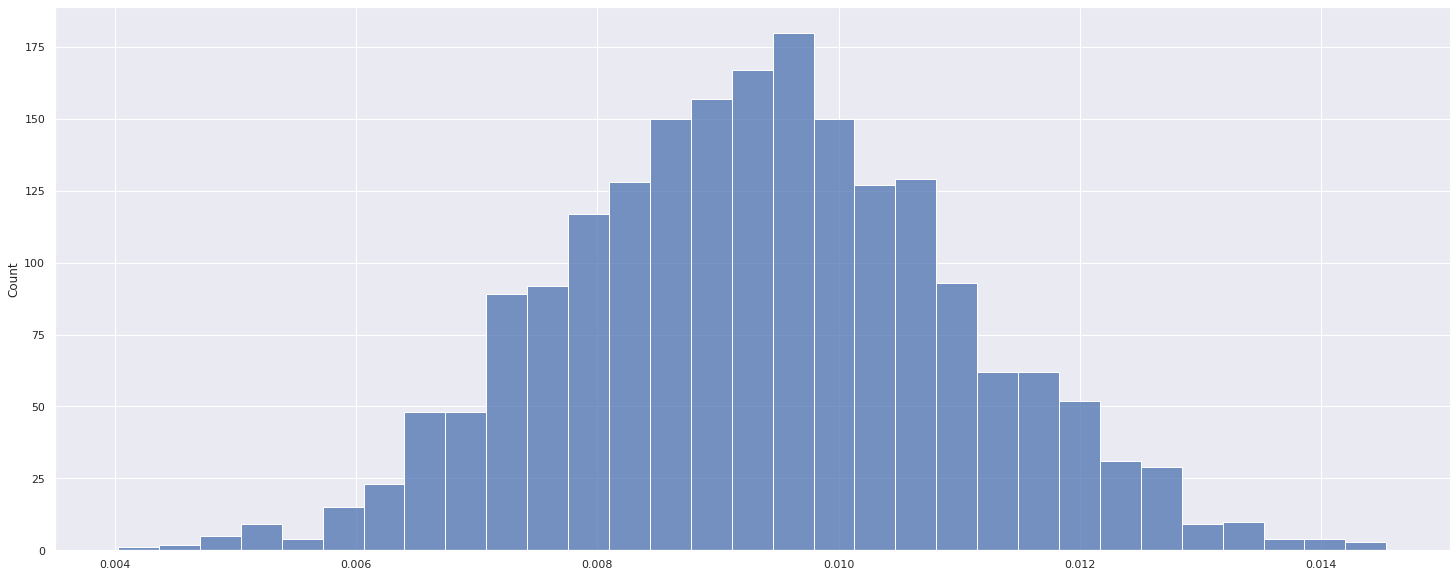

In [25]:
#Разница между глобальными CTR

sns.histplot(ctr1 - ctr2)

Разница между CTR есть и она не пересекает ноль, значит, вероятно разница между группами действительно есть.Проверим т-тестом поверх сглаженного CTR

In [26]:
#T-тест

stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=True)

Ttest_indResult(statistic=1.2493139639018758, pvalue=0.21156496041439202)

т-тест поверх сглаженного CTR не показывает стат значимых отличий

Теперь выполним тест Манна-Уитни и т-тест поверх бакетного преобразования.

In [27]:
q_5 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-01-31' and '2025-02-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

In [28]:
df_5 = pandahouse.read_clickhouse(q_5, connection=connection)

In [29]:
#тест Манна-Уитни поверх бакетного преобразования
stats.mannwhitneyu(df_5[df_5.exp_group == 1].bucket_ctr, 
                   df_5[df_5.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [42]:
#медианное значение бакетных CTR
median_group_1 = df_5[df_5.exp_group == 1].bucket_ctr.median()
median_group_2 = df_5[df_5.exp_group == 2].bucket_ctr.median()
  
print(f'Median Group 1 (Old System): {median_group_1}')
print(f'Median Group 2 (New System): {median_group_2}')

Median Group 1 (Old System): 0.20966742837276003
Median Group 2 (New System): 0.1979055389384647


Посколькоу тест Манна-Уитни и Манна-Уитни поверх бакетного преобразования показывают стат значимые различия, мы можем сделать вывод, что разница в алгоритмах есть. На результаты других тестов не стоит обращать внимание из-за характера распределения одной из групп (оно бимодально).

Медианное значение CTR и бакетное значение медиан у CTR показывают, что конверсия у новой системы хуже, значит она работает хуже и не стоит ее выпускать в прод.

Бимодальное распределение конверсий пользователей в группе с новой системой рекомендаций может указывать на несколько важных моментов, которые стоит учитывать:

1. Существование подгрупп: Бимодальность может свидетельствовать о том, что в нашей выборке пользователей есть две разные подгруппы, которые реагируют на рекомендации по-разному. Например, одна группа пользователей может активно взаимодействовать с контентом, в то время как другая — нет. Это может быть связано с различиями в интересах, предпочтениях или поведении пользователей.

2. Эффективность алгоритма: Если новый алгоритм рекомендаций работает значительно лучше для одной подгруппы пользователей и значительно хуже для другой, возможно алгоритм успешно находит релевантный контент для некоторых пользователей, но не для всех.

3. Также у нас может быть проблема с данными:

   • Неполные или некорректные данные

   • Наличие аномальных значений или выбросов в данных, которые искажают распределение.

   • Разные уровни вовлеченности пользователей (например, новые пользователи против старых).

4. Сегментация пользователей: Возможно, стоит рассмотреть возможность сегментации пользователей для более глубокого анализа. Например, можно разделить пользователей на группы по интересам или уровню активности и проанализировать, как новая система рекомендаций работает для каждой из этих групп.

5. Возможно есть другие факторы, которые негативно работают на алгоритм (например, время суток, тип контента и т.д.).

6. Новая система не показывает однородных результатов среди всех пользователей, это может быть сигналом о необходимости доработки алгоритма для улучшения его универсальности и эффективности.